# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

def identity(im):
    return im.ravel()

def normalize(img):
    img_max, img_min = np.max(img), np.min(img)
    img = 255.0 *(img - img_min) / (img_max - img_min)
    return img


In [4]:
from cs231n.features import *

num_color_bins = 64 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats   = extract_features(X_val, feature_fns)
X_test_feats  = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats   -= mean_feat
X_test_feats  -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats   /= std_feat
X_test_feats  /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7, 1e-6]
regularization_strengths = [1e2, 1e3, 1e4, 1e5]

results = {}
best_val = -1
best_svm = None

iters = 2000

for rate in learning_rates:
    for strength in regularization_strengths:
        print("learning rate",rate)
        print("regularization strength", strength)
        svm = LinearSVM()
        
        #train it
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=rate, reg=strength, num_iters=iters, verbose=False, batch_size=200)
        
        y_train_pred = svm.predict(X_train_feats)
        print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
        y_val_pred = svm.predict(X_val_feats)
        print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))
        
        accuracy_train = np.mean(y_train == y_train_pred)
        accuracy_valid = np.mean(y_val == y_val_pred)
        results[(rate, strength)] = (accuracy_train, accuracy_valid)
        
        if best_val < accuracy_valid:
            best_val = accuracy_valid
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

learning rate 1e-09
regularization strength 1000.0
training accuracy: 0.104347
validation accuracy: 0.089000
learning rate 1e-09
regularization strength 10000.0
training accuracy: 0.104592
validation accuracy: 0.105000
learning rate 1e-09
regularization strength 100000.0
training accuracy: 0.140571
validation accuracy: 0.147000
learning rate 1e-08
regularization strength 1000.0
training accuracy: 0.163000
validation accuracy: 0.156000
learning rate 1e-08
regularization strength 10000.0
training accuracy: 0.357816
validation accuracy: 0.382000
learning rate 1e-08
regularization strength 100000.0
training accuracy: 0.421367
validation accuracy: 0.428000
learning rate 1e-07
regularization strength 1000.0
training accuracy: 0.421980
validation accuracy: 0.437000
learning rate 1e-07
regularization strength 10000.0
training accuracy: 0.420694
validation accuracy: 0.424000
learning rate 1e-07
regularization strength 100000.0
training accuracy: 0.411408
validation accuracy: 0.410000
learning r

In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.43


In [7]:
from cs231n.features import *

num_color_bins = 32 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins), identity]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats   -= mean_feat
X_test_feats  -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats   /= std_feat
X_test_feats  /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [8]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-5, 1e-4, 1e-3]
regularization_strengths = [1e1, 5e1, 1e2]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
iters = 3500

for rate in learning_rates:
    for strength in regularization_strengths:
        print("learning rate",rate)
        print("regularization strength", strength)
        svm = LinearSVM()
        
        #train it
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=rate, reg=strength, num_iters=iters, verbose=False, batch_size=200)
        
        y_train_pred = svm.predict(X_train_feats)
        print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
        y_val_pred = svm.predict(X_val_feats)
        print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))
        
        accuracy_train = np.mean(y_train == y_train_pred)
        accuracy_valid = np.mean(y_val == y_val_pred)
        results[(rate, strength)] = (accuracy_train, accuracy_valid)
        
        if best_val < accuracy_valid:
            best_val = accuracy_valid
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

learning rate 1e-05
regularization strength 10.0
training accuracy: 0.456388
validation accuracy: 0.459000
learning rate 1e-05
regularization strength 50.0
training accuracy: 0.381163
validation accuracy: 0.394000
learning rate 1e-05
regularization strength 100.0
training accuracy: 0.357143
validation accuracy: 0.358000
learning rate 0.0001
regularization strength 10.0
training accuracy: 0.421857
validation accuracy: 0.435000
learning rate 0.0001
regularization strength 50.0
training accuracy: 0.350245
validation accuracy: 0.350000
learning rate 0.0001
regularization strength 100.0
training accuracy: 0.348245
validation accuracy: 0.364000
learning rate 0.001
regularization strength 10.0
training accuracy: 0.334694
validation accuracy: 0.351000
learning rate 0.001
regularization strength 50.0
training accuracy: 0.266776
validation accuracy: 0.286000
learning rate 0.001
regularization strength 100.0
training accuracy: 0.253776
validation accuracy: 0.251000
lr 1.000000e-05 reg 1.000000e+0

In [9]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.447


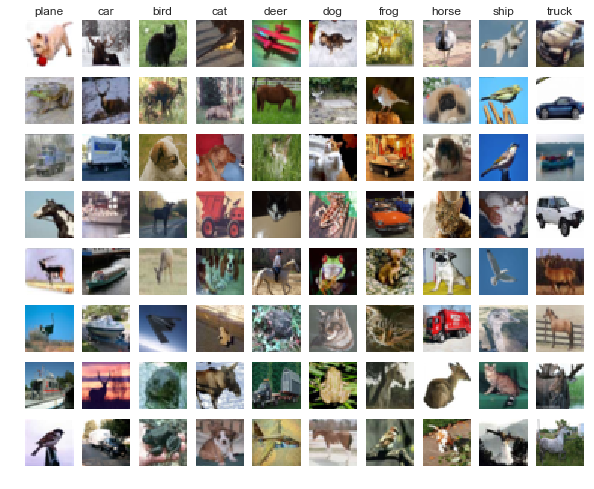

In [10]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    samples = min(examples_per_class, len(idxs))
    idxs = np.random.choice(idxs, samples, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
The mistakes encountered make sense when we consider input required to create the features. The color histogram feature creates a bias towards images with similar backgrounds or foregrounds as the same class. For example, a deer and other animals photographed against a green/brown background are commonly mis-classified. Similar, the HOG features cause us to put images with similar edges into the same category. The hard edges between car, truck, plane, and ship are quite similar, so the errors make sense.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [11]:
print(X_train_feats.shape)

(49000, 3249)


In [12]:
from cs231n.classifiers.neural_net import TwoLayerNet
from copy import deepcopy

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

hidden_size_set = [16, 32, 64, 128, 256, 512]
learning_rate   = [ 5e-2, 3e-2, 1e-2, 1e-3]
learning_rate_decay = [0.99, 0.97, 0.95, 0.90 ]
regularization_strength = [ 0.25, 0.5, 1.0, 1.5]

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
net.train(X_train_feats, y_train, X_val_feats, y_val,
          num_iters=600, batch_size = 200, learning_rate=5e-2,
          learning_rate_decay=0.95, reg=0.0, verbose=True)
best_net = deepcopy(net)
best_acc = (net.predict(X_val_feats) == y_val).mean()

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
for hs in hidden_size_set:
    for lr in learning_rate:
        net = TwoLayerNet(input_dim, hs, num_classes)

        # Train the network
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=1000, batch_size=400,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=0.05, verbose=True)

        # Predict on the validation set
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        print("hs=%d,lr=%f"%(hs,lr))
        print('Validation accuracy: ', val_acc)
        #print(net.best_val_acc)
        if val_acc > best_acc:
            best_acc = val_acc
            best_net = deepcopy(net)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 600: loss 2.302584
iteration 100 / 600: loss 1.627175
iteration 200 / 600: loss 1.386169
iteration 300 / 600: loss 1.439879
iteration 400 / 600: loss 1.324634
iteration 500 / 600: loss 1.592590
iteration 0 / 1000: loss 2.302598
iteration 100 / 1000: loss 1.790837
iteration 200 / 1000: loss 1.704083
iteration 300 / 1000: loss 1.751191
iteration 400 / 1000: loss 1.629054
iteration 500 / 1000: loss 1.678573
iteration 600 / 1000: loss 1.675715
iteration 700 / 1000: loss 1.685334
iteration 800 / 1000: loss 1.718439
iteration 900 / 1000: loss 1.598160
hs=16,lr=0.050000
Validation accuracy:  0.471
iteration 0 / 1000: loss 2.302598
iteration 100 / 1000: loss 1.823927
iteration 200 / 1000: loss 1.642367
iteration 300 / 1000: loss 1.607254
iteration 400 / 1000: loss 1.587253
iteration 500 / 1000: loss 1.573057
iteration 600 / 1000: loss 1.631943
iteration 700 / 1000: loss 1.554557
iteration 800 / 1000: loss 1.598861
iteration 900 / 1000: loss 1.642390
hs=16,lr=0.030000
Validation a

In [13]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.568


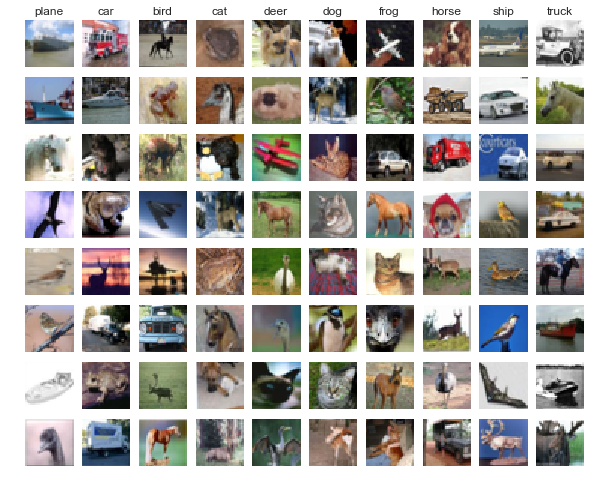

In [14]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    samples = min(examples_per_class, len(idxs))
    idxs = np.random.choice(idxs, samples, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

In [15]:
"""Compute the difference of Gaussian Filter feature for an image
     
        Uses scipy.ndimage.filters.gaussian_filter;

      Parameters:
        im : an input grayscale or rgb image
        i  : size of the standard deviation of the first gaussian_filter
        j  : size of the standard deviation of the second gaussian_filter

      Returns:
        feat: DoG 
  """
def dog_ij_feature(im,i=1,j=3,order=0):
    if i == j:
        raise ValueError("i=%d must not be equal to j=%d" % (i,j))

    from scipy.ndimage.filters import gaussian_filter
    if im.ndim == 3:
        image = rgb2gray(im)
    else:
        image = np.atleast_2d(im)
    sx, sy = image.shape # image size
    image_gaussian_i = gaussian_filter(image, sigma=i, order=order, mode='reflect', truncate=3.0)
    image_gaussian_j = gaussian_filter(image, sigma=j, order=order, mode='reflect', truncate=3.0)
    
    return (np.abs(image_gaussian_i - image_gaussian_j)/np.max(image_gaussian_i - image_gaussian_j)).ravel()

In [16]:
def sobel_feature(im, axis=-1):
    if im.ndim == 3:
        image = rgb2gray(im)
    else:
        image = np.at_least_2d(im)
    from scipy.ndimage.filters import sobel
    return sobel(image, axis=axis).ravel()

(-0.5, 31.5, 31.5, -0.5)

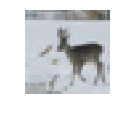

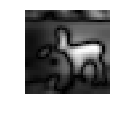

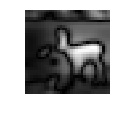

In [17]:
plt.figure(figsize=(1.5,1.5,))
plt.imshow(X_train[20].astype('uint8'))
plt.axis('off')
plt.figure(figsize=(1.5,1.5,))
plt.imshow(dog_ij_feature(X_train[20],1.,5,0).reshape(32,32).astype(np.float32))
plt.axis('off')
plt.figure(figsize=(1.5,1.5,))
test_image = dog_ij_feature(X_train[20],1,5,0)
#test_image[test_image < 0.75] = 0
plt.imshow(normalize(test_image).reshape(32,32).astype('uint8'))
plt.axis('off')


(32, 0)

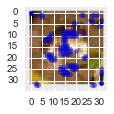

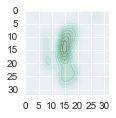

In [18]:
def dog_ij_feature_threshold(im, i=1, j=3, order=0, threshold=0.5):
    if i == j:
        raise ValueError("i=%d must not be equal to j=%d" % (i,j))

    from scipy.ndimage.filters import gaussian_filter
    if im.ndim == 3:
        image = rgb2gray(im)
    else:
        image = np.atleast_2d(im)
    sx, sy = image.shape # image size
    image_gaussian_i = gaussian_filter(image, sigma=i, order=order, mode='reflect', truncate=3.0)
    image_gaussian_j = gaussian_filter(image, sigma=j, order=order, mode='reflect', truncate=3.0)
    
    dog = (np.abs(image_gaussian_i - image_gaussian_j)/np.max(image_gaussian_i - image_gaussian_j)).ravel()
    mean     = np.mean(dog)
    std_dev  = np.std(dog)
    dog[dog < mean - std_dev * threshold] = 0
    return dog


def dog_ij_top_n_pixels(im, i=1, j=3, order=0, n_pixels = 20):
    idx = im.argsort()[-n_pixels:]    
    return idx

#NOT SURE ABOUT ORIENTATION
n_pixels = dog_ij_top_n_pixels(dog_ij_feature(X_train[0],1,3,0),n_pixels = 120)
#print(np.mean(np.unravel_index(list(n_pixels),(32,32)),axis=1))
#print(np.std(np.unravel_index(list(n_pixels),(32,32)),axis=1))

#print(np.unravel_index(list(n_pixels),(32,32)))
x = np.unravel_index(list(n_pixels),(32,32))[0] 
y = np.unravel_index(list(n_pixels),(32,32))[1]
#x = 32 - x
y = 32 - y


#have to flip the y axis because of the origin location
# sns.distplot(x, hist=False, rug=True, kde_kws = {"bw" :1.0})
# sns.distplot(y, hist=False, rug=True, kde_kws = {"bw" :1.0})

# plt.figure()
# sns.jointplot(x, y, kind="kde", size=7, space=0)

plt.figure(figsize=(1.5,1.5))
plt.imshow(X_train[0].astype('uint8'),origin="upper")
plt.scatter(x,y, alpha=0.5)
plt.scatter([0],[0])
plt.scatter([31],[31])

plt.figure(figsize=(1.5,1.5))
sns.kdeplot(x,y, shade=True,alpha=0.3)
plt.xlim([0,32])
plt.ylim([32,0])



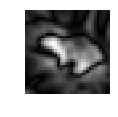

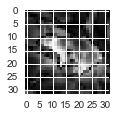

In [19]:
plt.figure(figsize=(1.5,1.5,))
plt.axis('off')
plt.imshow(dog_ij_feature(X_train[21],1,5,0).reshape(32,32))
#test_image = dog_ij_feature_threshold(X_train[20],1,5,0,0.5)
#test_image[test_image < 0.75] = 0
plt.figure(figsize=(1.5,1.5))
plt.imshow(normalize(dog_ij_feature(X_train[21],0.1,5,0).reshape(32,32)).astype('uint8'))

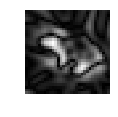

In [20]:
plt.figure(figsize=(1.5,1.5,))
plt.axis('off')
plt.imshow(normalize(dog_ij_feature(X_train[21],1,3,0)).reshape(32,32).astype('uint8'))

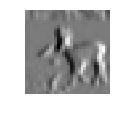

In [21]:
plt.figure(figsize=(1.5,1.5,))
plt.axis('off')
plt.imshow(sobel_feature(X_train[20]).reshape(32,32))

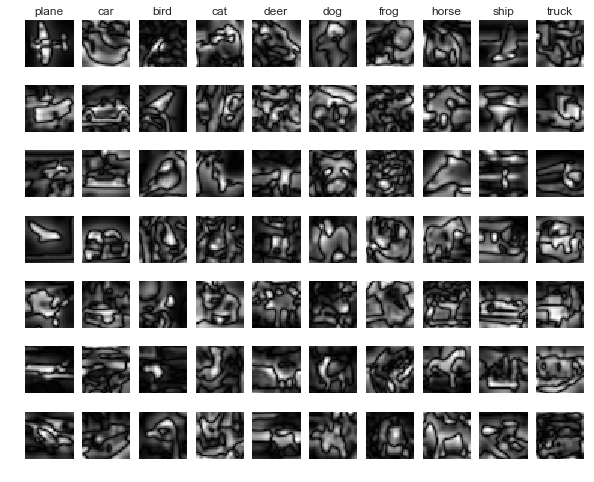

In [22]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(normalize(dog_ij_feature(X_train[idx],i=1,j=5,order=0).reshape(32,32)).astype(np.uint8))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

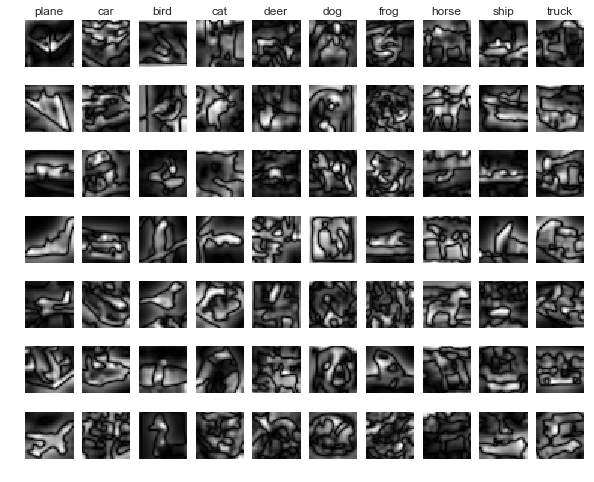

In [23]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        transformed_image = normalize(dog_ij_feature(X_train[idx],i=1,j=5,order=0)).astype(np.uint8)
        plt.imshow(transformed_image.reshape(32,32))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

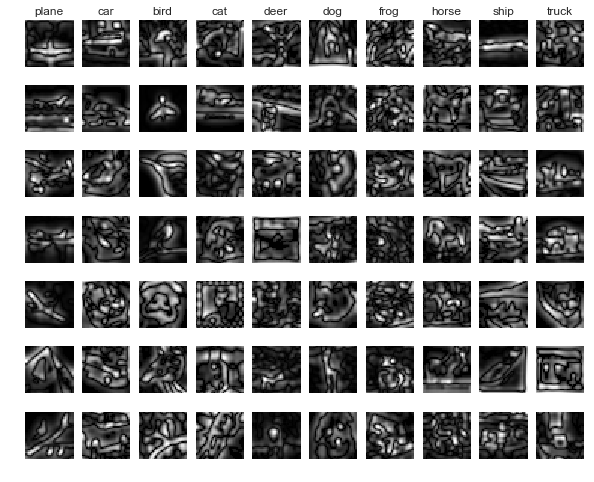

In [24]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        transformed_image = normalize(dog_ij_feature(X_train[idx],i=1,j=3,order=0)).astype(np.uint8)
        transformed_image[transformed_image < np.mean(transformed_image) - np.std(transformed_image)] = 0
        plt.imshow(transformed_image.reshape(32,32))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

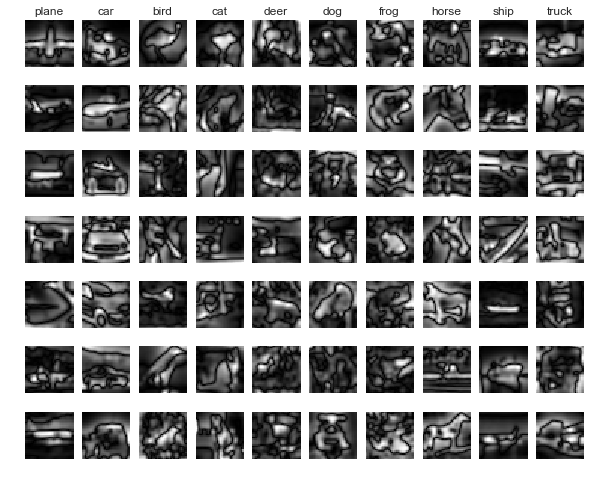

In [25]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(dog_ij_feature(X_train[idx].astype('uint8'),i=1,j=5,order=0).reshape(32,32).astype(np.float32))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

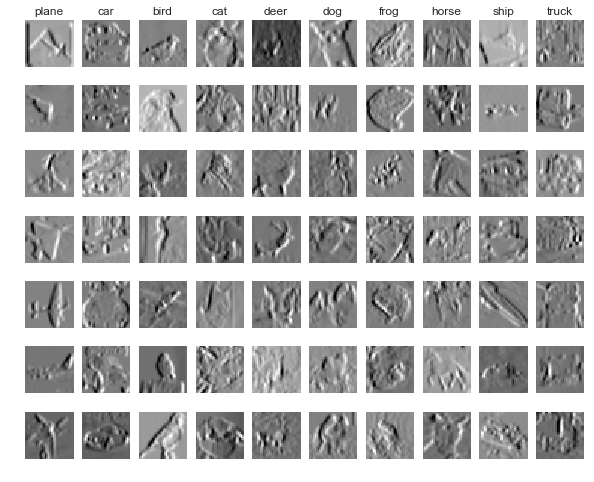

In [26]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(sobel_feature(X_train[idx].astype('uint8')).reshape(32,32))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [27]:
def generate_idx(image, count = 64):
    size = len(image.ravel())
    mask = np.random.random_integers(0, size, count)
    return mask

def sample_image(image, idx):
    return image[idx]

def single_color_image(im, color=0):
    if im.ndim != 3:
        raise ValueError("Invalid input image. Expected a numpy array with dim 3 (bgr).")
    if color < 0 or color > 3:
        raise ValueError("Color should be 0,1,2 (red, green, blue)")
    return im[:,:,color].ravel()

def single_channel_image(im, color=0):
    if im.ndim != 3:
        raise ValueError("Invalid input image. Expected a numpy array with dim 3 (bgr).")
    if color < 0 or color > 3:
        raise ValueError("Color should be 0,1,2 (red, green, blue)")
    channel_reduced = np.zeros(im.shape)
    channel_reduced[:,:,color] = single_color_image(im, color).reshape((im.shape[0],im.shape[1]))
    #return the image back in the same 3-dim format
    return channel_reduced

def patch_ravel(img, size=3):
    from sklearn.feature_extraction import image
    patches = image.extract_patches_2d(img, (size,size))
    list_of_patches = []
    for r in patches:
        list_of_patches.append(r.reshape(-1))
    return np.array(list_of_patches).ravel()

for x in list(range(2,30)):
    p = patch_ravel(X_train[1], x)
    print(p.shape)
    del p
    
#shape is (number of windows) x (3 * size * size)
#dimensionality of patch_ravel is too big for this laptop

(11532,)
(24300,)
(40368,)
(58800,)
(78732,)
(99372,)
(120000,)
(139968,)
(158700,)
(175692,)
(190512,)
(202800,)
(212268,)
(218700,)
(221952,)
(221952,)
(218700,)
(212268,)
(202800,)
(190512,)
(175692,)
(158700,)
(139968,)
(120000,)
(99372,)
(78732,)
(58800,)
(40368,)


In [28]:
feature_fns = [hog_feature,
               lambda img: color_histogram_hsv(img, nbin=num_color_bins),
               lambda image:  dog_ij_feature(image)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats   = extract_features(X_val, feature_fns)
X_test_feats  = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats   -= mean_feat
X_test_feats  -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats   /= std_feat
X_test_feats  /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])


Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [29]:
from cs231n.classifiers.neural_net import TwoLayerNet
from copy import deepcopy

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

hidden_size_set = [16, 32, 64, 128, 256, 512]
learning_rate   = [ 5e-2, 3e-2, 1e-2, 1e-3]
learning_rate_decay = [0.99, 0.97, 0.95, 0.90 ]
regularization_strength = [ 0.25, 0.5, 1.0, 1.5]

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
net.train(X_train_feats, y_train, X_val_feats, y_val,
          num_iters=600, batch_size = 200, learning_rate=1e-2,
          learning_rate_decay=0.95, reg=0.0, verbose=True)
best_net = deepcopy(net)
best_acc = (net.predict(X_val_feats) == y_val).mean()


iteration 0 / 600: loss 2.302586
iteration 100 / 600: loss 2.285854
iteration 200 / 600: loss 1.967509
iteration 300 / 600: loss 1.584449
iteration 400 / 600: loss 1.417495
iteration 500 / 600: loss 1.409000


1.44047579115 0.199162101098
1.04409898183 0.153247713517
1.0 0.141113486523


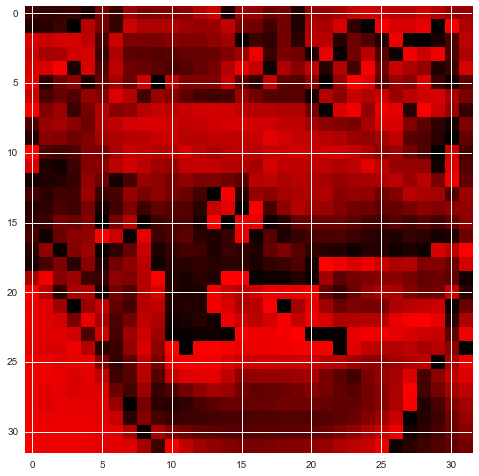

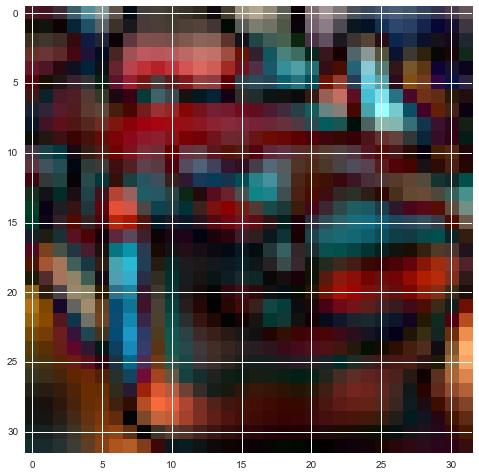

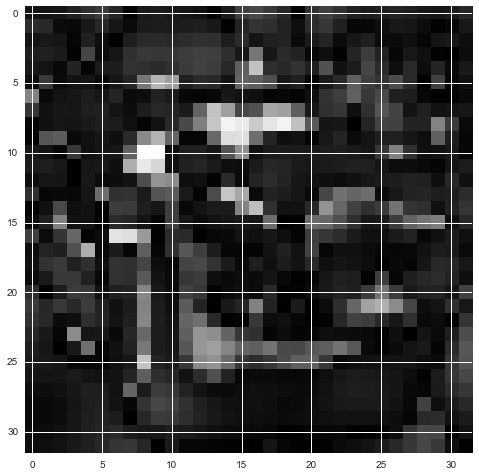

In [30]:
test = np.zeros(X_train[5].shape)
test = single_channel_image(X_train[5],0)


plt.imshow(normalize(test.astype('uint8')))


#plt.imshow(normalize(X_train[5]).reshape(32,32,3).astype('uint8'))

# plt.figure()
# plt.imshow(dog_ij_feature(single_channel_image(X_train[5],0)).reshape(32,32))
# plt.figure()
# plt.imshow(dog_ij_feature(single_channel_image(X_train[5],1)).reshape(32,32))
# plt.figure()
# plt.imshow(dog_ij_feature(single_channel_image(X_train[5],2)).reshape(32,32))

plt.figure()
channel_isolated_DOG = np.zeros(X_train[5].shape)
channel_isolated_DOG[:,:,0] = dog_ij_feature(single_channel_image(X_train[5],0),1,3).reshape(32,32)
channel_isolated_DOG[:,:,1] = dog_ij_feature(single_channel_image(X_train[5],1),1,3).reshape(32,32)
channel_isolated_DOG[:,:,2] = dog_ij_feature(single_channel_image(X_train[5],2),1,3).reshape(32,32)
plt.imshow(channel_isolated_DOG)

plt.figure()
gray_isolated_DOG = rgb2gray(channel_isolated_DOG)
plt.imshow(np.abs(gray_isolated_DOG - dog_ij_feature(X_train[5]).reshape(32,32)))


single_channel_dog = dict()
for k in range(3):
    single_channel_dog[k] = dog_ij_feature(single_channel_image(X_train[5],k),i=1,j=3,order=1)

for k in range(3):
    print(np.max(single_channel_dog[k]),np.mean(single_channel_dog[k]))


In [31]:
num_color_bins = 128 # Number of bins in the color histogram

feature_fns = [hog_feature,
               lambda img: color_histogram_hsv(img, nbin=num_color_bins),
               lambda image:  dog_ij_feature(image), 
               identity]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats   -= mean_feat
X_test_feats  -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats   /= std_feat
X_test_feats  /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats   = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats  = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

iteration 0 / 15000: loss 9.050464
iteration 100 / 15000: loss 3.494550
iteration 200 / 15000: loss 3.058163
iteration 300 / 15000: loss 2.622471
iteration 400 / 15000: loss 2.513380
iteration 500 / 15000: loss 2.380981
iteration 600 / 15000: loss 2.017348
iteration 700 / 15000: loss 2.515359
iteration 800 / 15000: loss 2.382169
iteration 900 / 15000: loss 2.233572
iteration 1000 / 15000: loss 2.251164
iteration 1100 / 15000: loss 2.218626
iteration 1200 / 15000: loss 2.083189
iteration 1300 / 15000: loss 2.225342
iteration 1400 / 15000: loss 2.214924
iteration 1500 / 15000: loss 1.723273
iteration 1600 / 15000: loss 1.895111
iteration 1700 / 15000: loss 1.928369
iteration 1800 / 15000: loss 1.954882
iteration 1900 / 15000: loss 1.466144
iteration 2000 / 15000: loss 2.571753
iteration 2100 / 15000: loss 2.020161
iteration 2200 / 15000: loss 1.728677
iteration 2300 / 15000: loss 2.020948
iteration 2400 / 15000: loss 2.038631
iteration 2500 / 15000: loss 2.107705
iteration 2600 / 15000: 

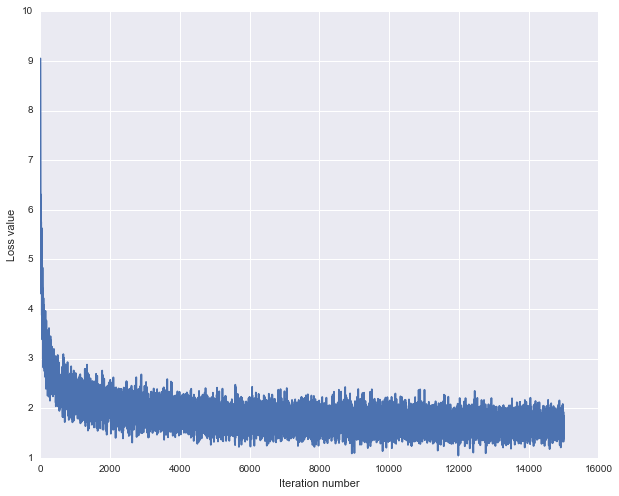

In [32]:
from cs231n.classifiers import LinearSVM
import time
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train_feats, y_train, learning_rate=1e-4, reg=0, num_iters=15000, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [33]:
y_test_pred = svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.551


In [34]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_size = X_train_feats.shape[1]
hidden_size = 512
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)
loss = net.train(X_train_feats, y_train,X_val_feats, y_val, num_iters=2000, batch_size=500,
                 learning_rate=1e-2, learning_rate_decay=0.90, reg=0.1, verbose=True)

iteration 0 / 2000: loss 2.303704
iteration 100 / 2000: loss 1.992635
iteration 200 / 2000: loss 1.781539
iteration 300 / 2000: loss 1.724149
iteration 400 / 2000: loss 1.650367
iteration 500 / 2000: loss 1.728324
iteration 600 / 2000: loss 1.695216
iteration 700 / 2000: loss 1.657007
iteration 800 / 2000: loss 1.625246
iteration 900 / 2000: loss 1.587226
iteration 1000 / 2000: loss 1.657001
iteration 1100 / 2000: loss 1.665161
iteration 1200 / 2000: loss 1.640121
iteration 1300 / 2000: loss 1.674780
iteration 1400 / 2000: loss 1.591009
iteration 1500 / 2000: loss 1.695100
iteration 1600 / 2000: loss 1.636188
iteration 1700 / 2000: loss 1.683351
iteration 1800 / 2000: loss 1.661957
iteration 1900 / 2000: loss 1.665879


In [35]:
y_test_pred = net.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.557


In [36]:
loss = net.train(X_train_feats, y_train, X_val_feats, y_val, num_iters=2000, batch_size=256,
                 learning_rate=1e-3, learning_rate_decay=0.95, reg=0, verbose=True)

iteration 0 / 2000: loss 1.373639
iteration 100 / 2000: loss 1.273151
iteration 200 / 2000: loss 1.273385
iteration 300 / 2000: loss 1.287888
iteration 400 / 2000: loss 1.272961
iteration 500 / 2000: loss 1.116622
iteration 600 / 2000: loss 1.255958
iteration 700 / 2000: loss 1.109831
iteration 800 / 2000: loss 1.190926
iteration 900 / 2000: loss 1.122204
iteration 1000 / 2000: loss 1.062177
iteration 1100 / 2000: loss 0.956502
iteration 1200 / 2000: loss 1.061654
iteration 1300 / 2000: loss 1.036553
iteration 1400 / 2000: loss 1.074001
iteration 1500 / 2000: loss 1.067733
iteration 1600 / 2000: loss 0.894053
iteration 1700 / 2000: loss 0.938861
iteration 1800 / 2000: loss 0.944051
iteration 1900 / 2000: loss 0.966084


In [37]:
y_test_pred = net.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.628


In [38]:
loss = net.train(X_train_feats, y_train, X_val_feats, y_val, num_iters=2000, batch_size=256,
                 learning_rate=1e-4, learning_rate_decay=0.95, reg=0, verbose=True)

iteration 0 / 2000: loss 0.965885
iteration 100 / 2000: loss 0.921980
iteration 200 / 2000: loss 0.913747
iteration 300 / 2000: loss 1.005698
iteration 400 / 2000: loss 0.963875
iteration 500 / 2000: loss 0.911021
iteration 600 / 2000: loss 0.879799
iteration 700 / 2000: loss 0.862285
iteration 800 / 2000: loss 0.926933
iteration 900 / 2000: loss 0.966811
iteration 1000 / 2000: loss 0.958116
iteration 1100 / 2000: loss 0.948557
iteration 1200 / 2000: loss 0.878194
iteration 1300 / 2000: loss 0.878638
iteration 1400 / 2000: loss 0.927809
iteration 1500 / 2000: loss 0.920302
iteration 1600 / 2000: loss 1.017955
iteration 1700 / 2000: loss 0.900585
iteration 1800 / 2000: loss 1.119097
iteration 1900 / 2000: loss 0.944657


In [39]:
y_test_pred = net.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.644


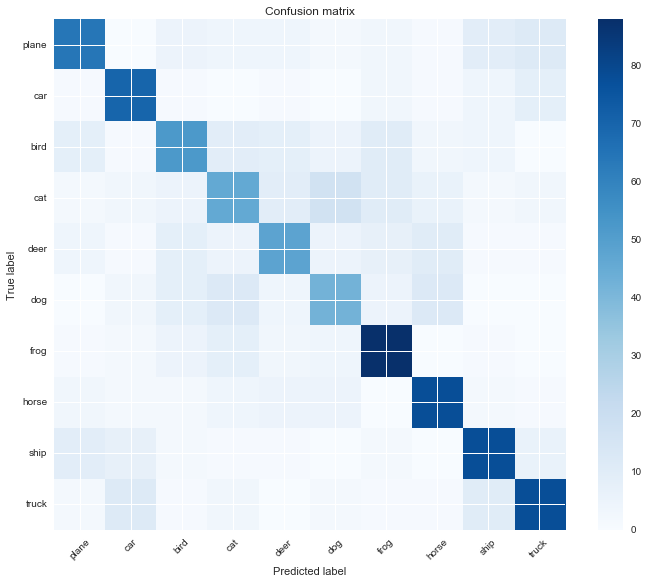

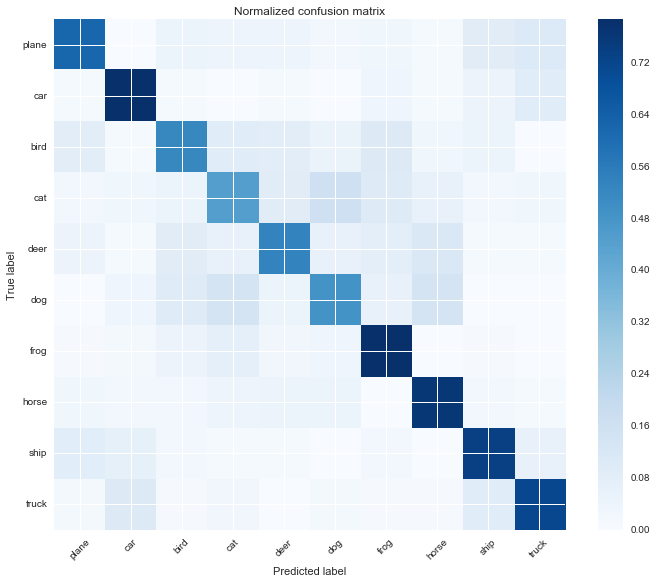

In [40]:
from sklearn.metrics import confusion_matrix

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

y_test_pred = net.predict(X_test_feats)
cm = confusion_matrix(y_test, y_test_pred)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=None):
    if labels is None:
        labels = list(range(len(cm)))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

plot_confusion_matrix(cm, labels=classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title="Normalized confusion matrix", labels=classes)

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!